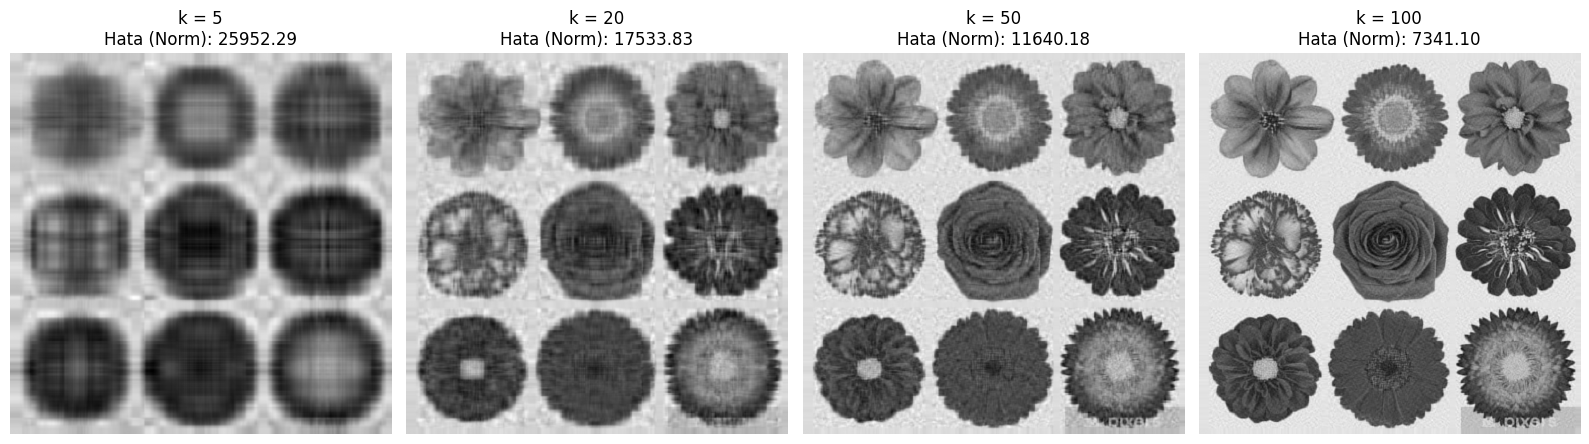

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# 1. RESMİ YÜKLEME VE HAZIRLAMA
def process_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Hata: '{image_path}' dosyası bulunamadı!")
    img = Image.open(image_path).convert('L') # Grayscale (Siyah-Beyaz) dönüşümü
    return np.array(img)

# 2. SVD SIKIŞTIRMA FONKSİYONU
def compress_svd(image_matrix, k):
    # Matrisi U, Sigma, VT parçalarına ayırır
    U, Sigma, VT = np.linalg.svd(image_matrix, full_matrices=False)
    
    # Sadece en büyük k adet tekil değeri kullanarak resmi yeniden oluşturur
    reconstructed_matrix = np.dot(U[:, :k], np.dot(np.diag(Sigma[:k]), VT[:k, :]))
    
    # Hata Analizi (Frobenius Normu)
    error = np.linalg.norm(image_matrix - reconstructed_matrix)
    return reconstructed_matrix, error

# --- ANA UYGULAMA BÖLÜMÜ ---
# ÖNEMLİ: Masaüstündeki resminin adını buraya yaz (örneğin 'deneme.jpg')
resim_adi = 'test_resmi.jpg' 

try:
    original_img = process_image(resim_adi)
    
    # Farklı k değerleri (tekil değer sayısı) deniyoruz
    # k ne kadar büyükse kalite artar, dosya boyutu büyür
    ks = [5, 20, 50, 100] 
    
    plt.figure(figsize=(16, 8))
    for i, k in enumerate(ks):
        reconstructed, err = compress_svd(original_img, k)
        plt.subplot(1, len(ks), i+1)
        plt.imshow(reconstructed, cmap='gray')
        plt.title(f"k = {k}\nHata (Norm): {err:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(e)
    print("\nİpucu: Resim dosyası ile bu kod dosyası aynı klasörde olmalıdır.")

In [8]:
# Küçük bir test matrisi üzerinde manuel SVD adımları
A_test = np.array([[1, 2], [3, 4], [5, 6]])
print("Test Matrisi A:\n", A_test)

# 1. At * A hesaplanır
AtA = np.dot(A_test.T, A_test)

# 2. Özdeğerler ve Özvektörler (V matrisi) bulunur
eigenvalues, V = np.linalg.eigh(AtA)

# 3. Tekil değerler (Sigma) özdeğerlerin kareköküdür
sigma = np.sqrt(np.maximum(eigenvalues, 0))
sigma = np.sort(sigma)[::-1] # Büyükten küçüğe sırala

print("\n--- Manuel Hesaplama Sonuçları ---")
print("Hesaplanan Tekil Değerler (Sigma):", sigma)

Test Matrisi A:
 [[1 2]
 [3 4]
 [5 6]]

--- Manuel Hesaplama Sonuçları ---
Hesaplanan Tekil Değerler (Sigma): [9.52551809 0.51430058]


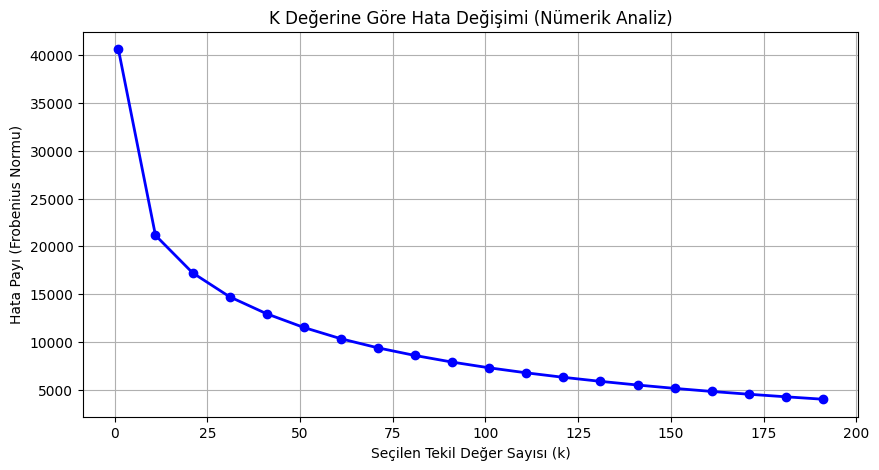

In [9]:
# 1. HATA ANALİZİ VE GRAFİKLEME
errors = []
k_values = range(1, 200, 10) # 1'den 200'e kadar 10'ar adımla dene

for k in k_values:
    _, err = compress_svd(original_img, k)
    errors.append(err)

plt.figure(figsize=(10, 5))
plt.plot(k_values, errors, 'b-o', linewidth=2)
plt.title('K Değerine Göre Hata Değişimi (Nümerik Analiz)')
plt.xlabel('Seçilen Tekil Değer Sayısı (k)')
plt.ylabel('Hata Payı (Frobenius Normu)')
plt.grid(True)
plt.show()

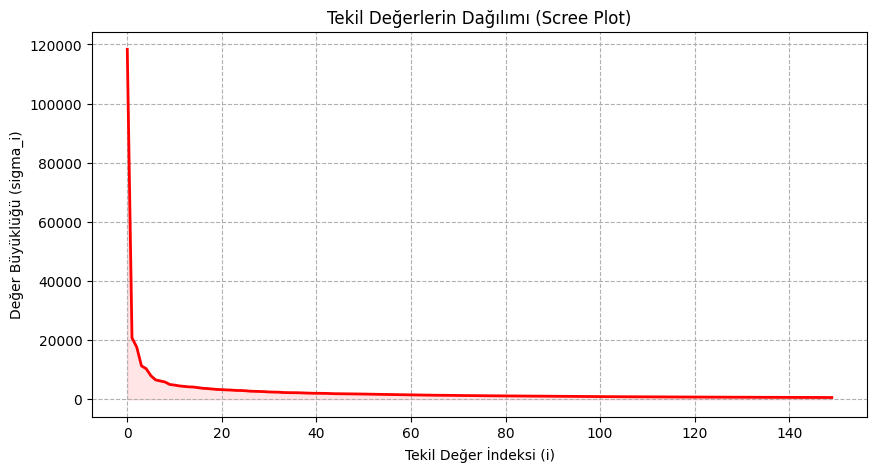

Scree Plot başarıyla oluşturuldu.


In [10]:
# Hata almamak için SVD'yi bu hücrede tekrar tanımlıyoruz
# original_img'nin daha önceki hücrelerde tanımlanmış olması gerekir
try:
    U, Sigma, VT = np.linalg.svd(original_img, full_matrices=False)

    plt.figure(figsize=(10, 5))
    plt.plot(Sigma[:150], 'r-', linewidth=2)
    plt.fill_between(range(150), Sigma[:150], color='red', alpha=0.1)
    plt.title('Tekil Değerlerin Dağılımı (Scree Plot)')
    plt.xlabel('Tekil Değer İndeksi (i)')
    plt.ylabel('Değer Büyüklüğü (sigma_i)')
    plt.grid(True, linestyle='--')
    plt.show()
    
    print("Scree Plot başarıyla oluşturuldu.")
except NameError:
    print("Hata: 'original_img' bulunamadı. Lütfen önce resmin yüklendiği hücreyi çalıştırın.")

In [11]:
# 2. KARŞILAŞTIRMA TABLOSU İÇİN VERİ ÜRETME
print(f"{'k Değeri':<10} | {'Hata Miktarı':<15} | {'Sıkıştırma Oranı (%)'}")
print("-" * 50)

m, n = original_img.shape
original_size = m * n

for k in [5, 20, 50, 100, 200]:
    _, err = compress_svd(original_img, k)
    # SVD'de saklanan veri: (m*k + k + n*k)
    compressed_size = (m * k) + k + (n * k)
    ratio = (1 - (compressed_size / original_size)) * 100
    print(f"{k:<10} | {err:<15.2f} | %{ratio:.2f}")

k Değeri   | Hata Miktarı    | Sıkıştırma Oranı (%)
--------------------------------------------------
5          | 25952.29        | %98.57
20         | 17533.83        | %94.28
50         | 11640.18        | %85.70
100        | 7341.10         | %71.41
200        | 3785.77         | %42.82


In [12]:
# YENİ HÜCRE: Enerji Korunumu Analizi
# Orijinal resmin tüm tekil değerlerini alıyoruz
U, Sigma, VT = np.linalg.svd(original_img, full_matrices=False)
total_energy = np.sum(Sigma**2) # Toplam enerji (Frobenius Normu karesi)

print(f"{'k Değeri':<10} | {'Korunan Enerji (%)':<20}")
print("-" * 35)

for k in [5, 20, 50, 100, 200]:
    energy_kept = np.sum(Sigma[:k]**2)
    percentage = (energy_kept / total_energy) * 100
    print(f"{k:<10} | %{percentage:.2f}")

k Değeri   | Korunan Enerji (%)  
-----------------------------------
5          | %95.70
20         | %98.04
50         | %99.13
100        | %99.66
200        | %99.91
